# 230117_1424_확인

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# cd "/content/drive/My Drive/Colab Notebooks/code_240116_0133"

In [1]:
# 파이썬 버전 확인
import sys
assert sys.version_info >= (3, 5)

# 사이킷런 버전 확인
import sklearn
assert sklearn.__version__ >= "0.20"

# 텐서플로 버전 확인
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

# colab 사용여부 판단
try:
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# GPU 사용 여부 판단
if not tf.config.list_physical_devices('GPU'):
    print("감지된 GPU가 없습니다. GPU가 없으면 LSTM과 CNN이 매우 느릴 수 있습니다.")
    if IS_COLAB:
        print("런타임 > 런타임 유형 변경 메뉴를 선택하고 하드웨어 가속기로 GPU를 고르세요.")

# 공통 모듈 임포트
import numpy as np
import matplotlib.pyplot as plt
import pickle

# 난수 지정
# 시드를 42로 지정하여 모든 실행결과에서 시드42의 난수를 생성하도록 지정
# 노트북 실행 결과를 동일하게 유지
np.random.seed(42)
tf.random.set_seed(42)

# 그래프 출력 설정
%matplotlib inline
import matplotlib as mpl
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [2]:
# 정확도 계산 함수
def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

'''
모델의 이진 분류 작업에 사용할 수 있는 평가 지표
실제 정답과 예측값을 반올림하여 정확도를 계산
예측값이 실수 형태로 주어지더라도 이진 분류 작업에서의 정확도 평가 가능

y_true(정답값) 및 y_pred(예측값) 두 개의 인자를 받음

tf.round()를 사용하여 실제 정답값과 예측값을 반올림하여 예측된 클래스를 이진형태로 변환(0 또는 1)

keras.metrics.binary_accuracy 함수를 사용하여
반올림된 실제 정답값과 반올림된 예측값 사이의 이진 분류 정확도(binary accuracy)를 계산
'''

'\n모델의 이진 분류 작업에 사용할 수 있는 평가 지표\n실제 정답과 예측값을 반올림하여 정확도를 계산\n예측값이 실수 형태로 주어지더라도 이진 분류 작업에서의 정확도 평가 가능\n\ny_true(정답값) 및 y_pred(예측값) 두 개의 인자를 받음\n\ntf.round()를 사용하여 실제 정답값과 예측값을 반올림하여 예측된 클래스를 이진형태로 변환(0 또는 1)\n\nkeras.metrics.binary_accuracy 함수를 사용하여\n반올림된 실제 정답값과 반올림된 예측값 사이의 이진 분류 정확도(binary accuracy)를 계산\n'

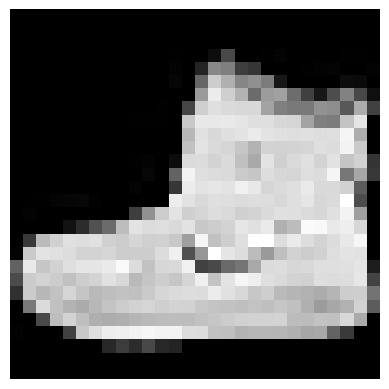

================= shape ==================
X_train : (55000, 28, 28)
y_train : (55000,)

X_valid : (5000, 28, 28)
y_valid : (5000,)

X_test  : (10000, 28, 28)
y_test  : (10000,)

================= type ==================
X_train : <class 'numpy.ndarray'>
y_train : <class 'numpy.ndarray'>

X_valid : <class 'numpy.ndarray'>
y_valid : <class 'numpy.ndarray'>

X_test  : <class 'numpy.ndarray'>
y_test  : <class 'numpy.ndarray'>




In [3]:
# AE에 사용할 MNIST 데이터를 불러오기
def mnist_data_load():

    ########## data 불러오기 ##########
    (X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
    
    ########## data 타입 변경 ##########
    X_train_full = X_train_full.astype(np.float32) / 255
    X_test = X_test.astype(np.float32) / 255

    ########## 학습용데이터와 검증용데이터로 분리 ##########
    X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
    y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

    ########## 각 데이터를 반환 ##########
    return X_train, X_valid, X_test, y_train, y_valid, y_test



X_train, X_valid, X_test, y_train, y_valid, y_test = mnist_data_load()

########## 데이터 형태 확인하기 ##########
plt.imshow(X_train[0], cmap='gray')
plt.axis('off')
plt.show()
print('================= shape ==================') 
print('X_train :', np.shape(X_train))
print('y_train :', np.shape(y_train))
print()
print('X_valid :', np.shape(X_valid))
print('y_valid :', np.shape(y_valid))
print()
print('X_test  :', np.shape(X_test))
print('y_test  :', np.shape(y_test))
print()
print('================= type ==================') 
print('X_train :', type(X_train))
print('y_train :', type(y_train))
print() 
print('X_valid :', type(X_valid))
print('y_valid :', type(y_valid))
print() 
print('X_test  :', type(X_test))
print('y_test  :', type(y_test))
print()
print('============================================')
print()

In [6]:
# AE 모델 생성
def make_ae_model():

    ########## 난수 지정 ##########
    tf.random.set_seed(42)
    np.random.seed(42)

    ########## 인코더 생성 ##########
    stacked_encoder = keras.models.Sequential([
        keras.layers.Flatten(input_shape=[28, 28]),
        keras.layers.Dense(100, activation="selu"),
        keras.layers.Dense(30, activation="selu"),])

    ########## 디코더 생성 ##########
    stacked_decoder = keras.models.Sequential([
        keras.layers.Dense(100, activation="selu", input_shape=[30]),
        keras.layers.Dense(28 * 28, activation="sigmoid"),
        keras.layers.Reshape([28, 28])])

    ########## 오토인코더 모델 생성 ##########
    # 인코더와 디코더를 합쳐서 하나의 오토인코더 모델을 생성
    ae_model = keras.models.Sequential([stacked_encoder, stacked_decoder])

    ########## 모델 컴파일 후 반환 ##########
    ae_model.compile(
        loss="binary_crossentropy",
        optimizer=keras.optimizers.SGD(learning_rate=1.5),
        metrics=[rounded_accuracy])
    stacked_encoder.summary()
    stacked_decoder.summary()
    return ae_model



ae_model = make_ae_model()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 dense_4 (Dense)             (None, 100)               78500     
                                                                 
 dense_5 (Dense)             (None, 30)                3030      
                                                                 
Total params: 81,530
Trainable params: 81,530
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 100)               3100      
                                                                 
 dense_7 (Dense)            

In [7]:
# AE 모델을 학습
def train_ae_model(ae_model, X_train, X_valid, epochs_num, model_path ,hist_path):

    ########## AE 모델 학습 ##########
    ae_history = ae_model.fit(X_train, X_train, epochs=epochs_num, validation_data=(X_valid, X_valid))

    ########## AE 모델 학습기록 및 결과 저장 ##########
    ae_model.save(model_path)
    with open(hist_path, 'wb') as file:
        pickle.dump(ae_history.history, file)

    return ae_history, ae_model



epochs_num = 5
model_path = 'ckpt_AE_MNIST_model'
hist_path  = 'ckpt_AE_MNIST_hist'
ae_history, ae_model = train_ae_model(ae_model, X_train, X_valid, epochs_num, model_path ,hist_path)

Epoch 1/5


2024-01-17 13:49:00.967493: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


   9/1719 [..............................] - ETA: 23s - loss: 0.6769 - rounded_accuracy: 0.5723 

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/0032d1ee-80fd-11ee-8227-6aecfccc70fe/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<32x28x1x28xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/0032d1ee-80fd-11ee-8227-6aecfccc70fe/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<32x28x1x28xi1>'


1719/1719 [==============================] - ETA: 0s - loss: 0.3381 - rounded_accuracy: 0.8870

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/0032d1ee-80fd-11ee-8227-6aecfccc70fe/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<24x28x1x28xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/0032d1ee-80fd-11ee-8227-6aecfccc70fe/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<24x28x1x28xi1>'
2024-01-17 13:49:23.945545: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.

1719/1719 [==============================] - 24s 14ms/step - loss: 0.3381 - rounded_accuracy: 0.8870 - val_loss: 0.3166 - val_rounded_accuracy: 0.9003
Epoch 2/5
1719/1719 [==============================] - 24s 14ms/step - loss: 0.3056 - rounded_accuracy: 0.9152 - val_loss: 0.3021 - val_rounded_accuracy: 0.9198
Epoch 3/5
1719/1719 [==============================] - 24s 14ms/step - loss: 0.2986 - rounded_accuracy: 0.9215 - val_loss: 0.2986 - val_rounded_accuracy: 0.9198
Epoch 4/5
1719/1719 [==============================] - 22s 13ms/step - loss: 0.2948 - rounded_accuracy: 0.9249 - val_loss: 0.2938 - val_rounded_accuracy: 0.9285
Epoch 5/5
1719/1719 [==============================] - 22s 13ms/step - loss: 0.2923 - rounded_accuracy: 0.9272 - val_loss: 0.2919 - val_rounded_accuracy: 0.9285
INFO:tensorflow:Assets written to: ckpt_CNN_MNIST_model/assets


In [8]:
# AE 모델 검증
# loss, accuracy
ae_model.evaluate(X_test, X_test)

313/313 [==============================] - 3s 8ms/step - loss: 0.2924 - rounded_accuracy: 0.9280


[0.29240182042121887, 0.9279903173446655]

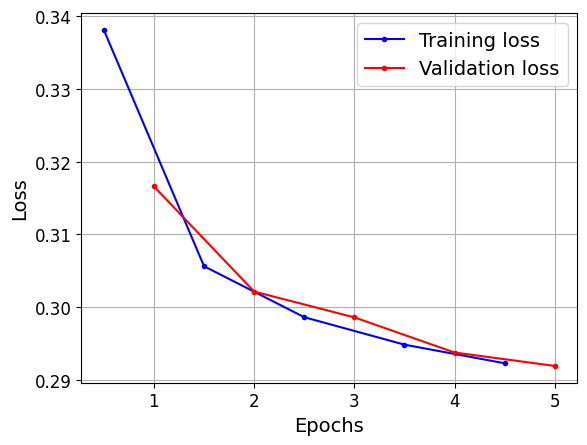

In [9]:
# loss 그래프를 그리는 함수
# 학습하는 동안의 loss의 변화를 시각화
def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training loss")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label="Validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    # plt.axis([1, 20, 0, 0.05])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.show()



# 학습하는 동안의 loss의 변화를 시각화
plot_learning_curves(ae_history.history["loss"], ae_history.history["val_loss"])

1/1 [==============================] - 0s 28ms/step


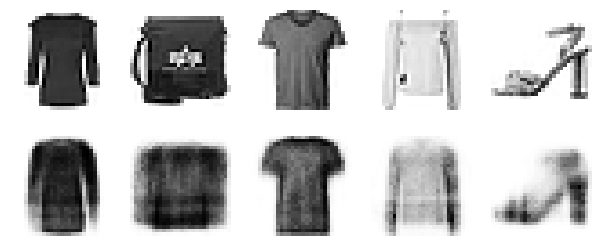

In [12]:
# 학습한 모델로 이미지 재구성
def result_show(ae_model, X_valid, show_num):

    ########## 이미지 재구성 ##########
    # X_valid안에서 원하는 양만큼의 이미지를 재구성
    #            X_valid : (5000, 28, 28)
    # X_valid[:show_num] : (5, 28, 28)      # 본 코드에서는 5개 선택
    #    reconstructions : (5, 28, 28)
    reconstructions = ae_model.predict(X_valid[:show_num])

    ########## 결과 시각화 ##########
    # 윗줄은 원본 이미지
    # 아래줄은 재구성 이미지
    plt.figure(figsize=(show_num * 1.5, 3))
    for image_index in range(show_num):
        plt.subplot(2, show_num, 1 + image_index)
        plt.imshow(X_valid[image_index], cmap="binary")
        plt.axis("off")
        plt.subplot(2, show_num, 1 + show_num + image_index)
        plt.imshow(reconstructions[image_index], cmap="binary")
        plt.axis("off")
    plt.show()


# X_train X_valid X_test
show_num = 5
result_show(ae_model, X_valid, show_num)

1/1 [==============================] - 0s 70ms/step


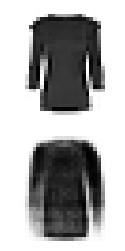

In [13]:
# 학습한 모델을 이용하여 이미지 하나만 재구성하는 방법 
def result_show_one(ae_model, X_valid, show_index):

    ########## 재구성할 이미지 선택 ##########
    test_image = X_valid[show_index]
    test_image = np.array([test_image])

    ########## 이미지 재구성 ##########
    #     test image : (1, 28, 28)
    # reconstruction : (1, 28, 28)
    reconstruction = ae_model.predict(test_image)

    ########## 결과 시각화 ##########
    plt.figure(figsize=(6, 3))
    plt.subplot(211)
    plt.imshow(X_valid[show_index], cmap="binary")
    plt.axis("off")
    plt.subplot(212)
    plt.imshow(reconstruction[0], cmap="binary")
    plt.axis("off")
    plt.show()



show_index = 0
result_show_one(ae_model, X_valid, show_index)

# 런타임 재시작

In [1]:
import sys
assert sys.version_info >= (3, 5)
import sklearn
assert sklearn.__version__ >= "0.20"
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"
try:
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False
if not tf.config.list_physical_devices('GPU'):
    print("감지된 GPU가 없습니다. GPU가 없으면 LSTM과 CNN이 매우 느릴 수 있습니다.")
    if IS_COLAB:
        print("런타임 > 런타임 유형 변경 메뉴를 선택하고 하드웨어 가속기로 GPU를 고르세요.")
import numpy as np
import matplotlib.pyplot as plt
import pickle
np.random.seed(42)
tf.random.set_seed(42)
%matplotlib inline
import matplotlib as mpl
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

def mnist_data_load():
    (X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
    X_train_full = X_train_full.astype(np.float32) / 255
    X_test = X_test.astype(np.float32) / 255
    X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
    y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]
    return X_train, X_valid, X_test, y_train, y_valid, y_test

def make_ae_model():
    tf.random.set_seed(42)
    np.random.seed(42)
    stacked_encoder = keras.models.Sequential([
        keras.layers.Flatten(input_shape=[28, 28]),
        keras.layers.Dense(100, activation="selu"),
        keras.layers.Dense(30, activation="selu"),])
    stacked_decoder = keras.models.Sequential([
        keras.layers.Dense(100, activation="selu", input_shape=[30]),
        keras.layers.Dense(28 * 28, activation="sigmoid"),
        keras.layers.Reshape([28, 28])])
    ae_model = keras.models.Sequential([stacked_encoder, stacked_decoder])
    ae_model.compile(
        loss="binary_crossentropy",
        optimizer=keras.optimizers.SGD(learning_rate=1.5),
        metrics=[rounded_accuracy])
    stacked_encoder.summary()
    stacked_decoder.summary()
    return ae_model

def train_ae_model(ae_model, X_train, X_valid, epochs_num, model_path ,hist_path):
    ae_history = ae_model.fit(X_train, X_train, epochs=epochs_num, validation_data=(X_valid, X_valid))
    ae_model.save(model_path)
    with open(hist_path, 'wb') as file:
        pickle.dump(ae_history.history, file)
    return ae_history, ae_model

def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training loss")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label="Validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    # plt.axis([1, 20, 0, 0.05])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.show()

def result_show(ae_model, X_valid, show_num):
    reconstructions = ae_model.predict(X_valid[:show_num])
    plt.figure(figsize=(show_num * 1.5, 3))
    for image_index in range(show_num):
        plt.subplot(2, show_num, 1 + image_index)
        plt.imshow(X_valid[image_index], cmap="binary")
        plt.axis("off")
        plt.subplot(2, show_num, 1 + show_num + image_index)
        plt.imshow(reconstructions[image_index], cmap="binary")
        plt.axis("off")
    plt.show()
    
def result_show_one(ae_model, X_valid, show_index):
    test_image = X_valid[show_index]
    test_image = np.array([test_image])
    reconstruction = ae_model.predict(test_image)
    plt.figure(figsize=(6, 3))
    plt.subplot(211)
    plt.imshow(X_valid[show_index], cmap="binary")
    plt.axis("off")
    plt.subplot(212)
    plt.imshow(reconstruction[0], cmap="binary")
    plt.axis("off")
    plt.show()

Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



2024-01-17 14:15:57.171939: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-01-17 14:15:57.172354: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 100)               78500     
                                                                 
 dense_1 (Dense)             (None, 30)                3030      
                                                                 
Total params: 81,530
Trainable params: 81,530
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 100)               3100      
                                                                 
 dense_3 (Dense)             (

2024-01-17 14:15:57.684927: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2024-01-17 14:15:57.924562: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


   9/1719 [..............................] - ETA: 22s - loss: 0.6769 - rounded_accuracy: 0.5723 

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/0032d1ee-80fd-11ee-8227-6aecfccc70fe/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<32x28x1x28xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/0032d1ee-80fd-11ee-8227-6aecfccc70fe/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<32x28x1x28xi1>'


1719/1719 [==============================] - ETA: 0s - loss: 0.3381 - rounded_accuracy: 0.8870

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/0032d1ee-80fd-11ee-8227-6aecfccc70fe/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<24x28x1x28xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/0032d1ee-80fd-11ee-8227-6aecfccc70fe/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<24x28x1x28xi1>'
2024-01-17 14:16:22.113291: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.

1719/1719 [==============================] - 26s 15ms/step - loss: 0.3381 - rounded_accuracy: 0.8870 - val_loss: 0.3166 - val_rounded_accuracy: 0.9003
Epoch 2/2
1719/1719 [==============================] - 23s 14ms/step - loss: 0.3056 - rounded_accuracy: 0.9152 - val_loss: 0.3021 - val_rounded_accuracy: 0.9198
INFO:tensorflow:Assets written to: ckpt_AE_MNIST_model/assets
313/313 [==============================] - 2s 7ms/step - loss: 0.3026 - rounded_accuracy: 0.9192


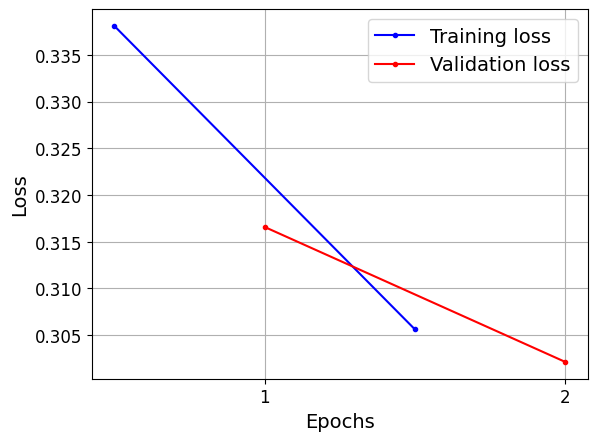

1/1 [==============================] - 0s 96ms/step


2024-01-17 14:16:49.886265: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


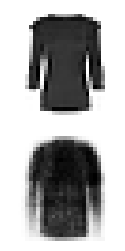

1/1 [==============================] - 0s 48ms/step


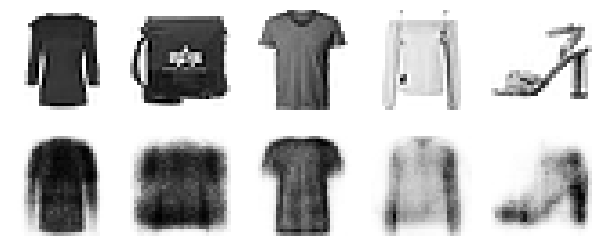

In [2]:
# 전체 한번에 실행

epochs_num = 2
num_samples = 5
show_index = 0
model_path = 'ckpt_AE_MNIST_model'
hist_path  = 'ckpt_AE_MNIST_hist'

# 데이터
X_train, X_valid, X_test, y_train, y_valid, y_test = mnist_data_load() # mnist 데이터 불러오기

# 학습
ae_model = make_ae_model() # AE 모델 생성
ae_history, ae_model = train_ae_model(ae_model, X_train, X_valid, epochs_num, model_path ,hist_path) # AE 모델 학습 ############
ae_model.evaluate(X_test, X_test) # AE 모델 검증

# 학습기록
plot_learning_curves(ae_history.history["loss"], ae_history.history["val_loss"]) # loss 그래프 그리기

# 이미지 재구성
result_show_one(ae_model, X_valid, show_index)
result_show(ae_model, X_valid, num_samples)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 dense_4 (Dense)             (None, 100)               78500     
                                                                 
 dense_5 (Dense)             (None, 30)                3030      
                                                                 
Total params: 81,530
Trainable params: 81,530
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 100)               3100      
                                                                 
 dense_7 (Dense)            

2024-01-17 14:16:57.146389: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ckpt_AE_MNIST_model: FAILED_PRECONDITION: ckpt_AE_MNIST_model; Is a directory: perhaps your file is in a different file format and you need to use a different restore operator?
2024-01-17 14:16:57.303197: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - 3s 8ms/step - loss: 0.3026 - rounded_accuracy: 0.9192


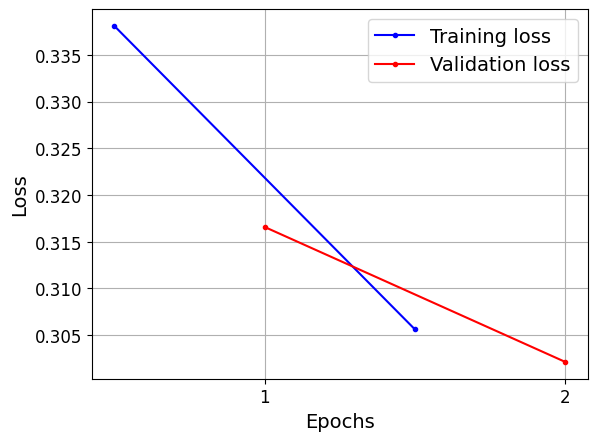

1/1 [==============================] - 0s 62ms/step


2024-01-17 14:16:59.964975: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


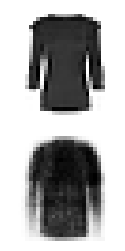

1/1 [==============================] - 0s 32ms/step


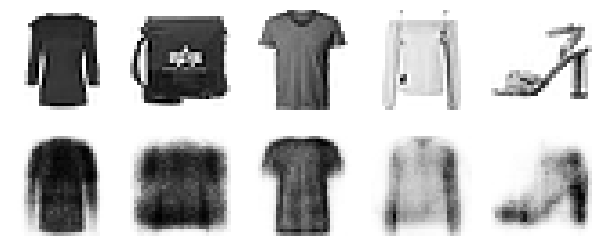

In [3]:
# 기존에 저장한 AE 모델 사용

num_samples = 5
show_index = 0
model_path = 'ckpt_AE_MNIST_model'
hist_path  = 'ckpt_AE_MNIST_hist'

# 데이터
X_train, X_valid, X_test, y_train, y_valid, y_test = mnist_data_load() # mnist 데이터 불러오기

# 학습
new_ae_model = make_ae_model() # AE 모델 생성
new_ae_model.load_weights(model_path) # AE 모델 불러오기 ############
new_ae_model.evaluate(X_test, X_test) # AE 모델 검증

# 학습기록
new_ae_history = pickle.load(open(hist_path, "rb"))
plot_learning_curves(new_ae_history["loss"], new_ae_history["val_loss"]) # loss 그래프 그리기

# 이미지 재구성
result_show_one(new_ae_model, X_valid, show_index)
result_show(new_ae_model, X_valid, num_samples)

1/1 [==============================] - 0s 57ms/step


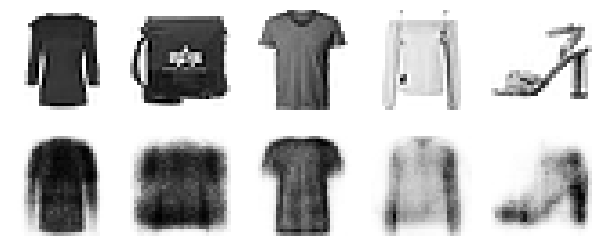

1/1 [==============================] - 0s 19ms/step


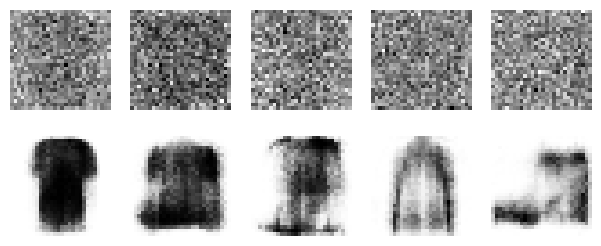

1/1 [==============================] - 0s 14ms/step


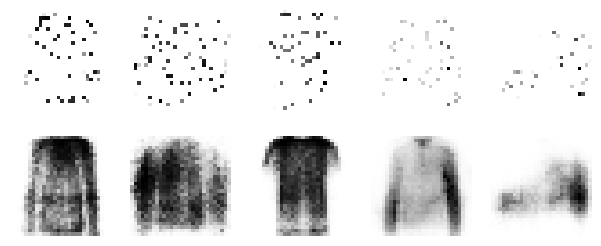

In [21]:
# 노이즈 추가
noise = keras.layers.GaussianNoise(1.0)
dropout = keras.layers.Dropout(0.9)

num_samples = 5
result_show(new_ae_model, X_valid, num_samples)
result_show(new_ae_model, noise(X_valid, training=True), num_samples)
result_show(new_ae_model, dropout(X_valid, training=True), num_samples)